In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_banded
from matplotlib import pyplot as plt

In [4]:
def a(i, j, epsilon, x0, x1, x2):
    """
    Paramaters:
        i (int): index of phi function
        j (int): index of phi function
        epsilon (float): constant
        interval (tuple): (x0, x1, x3) partition x values
    Returns:
        result (float): evaluation of function 
    """
    interval = (x0, x1, x2)
    h_i = interval[1] - interval[0]
    h_i_1 = interval[2] - interval[1]
    if j == i+1:
        return epsilon/h_i_1 + 1/2
    elif i == j:
        return -epsilon/h_i - epsilon/h_i_1
    elif j == i-1:
        return epsilon/h_i - 1/2
    else:
        return 0
    
def l(j, x0, x1, x2):
    """
    Parameters:
        j (int): index of phi function
        interval (tuple): (x0, x1, x3) partition x values 
    Returns:
        result (float): value of l function
    """
    interval = (x0, x1, x2)
    h_j = interval[1] - interval[0]
    h_j_1 = interval[2] - interval[1]
    return -1/2*(h_j + h_j_1)

l = np.vectorize(l)
a = np.vectorize(a)

In [37]:
def finite_element(epsilon, alpha, beta, xmin, xmax, N, special=None):
    """
    Parameters:
        epsilon (float): constant
        alpha (float): y(xmin) = alpha
        beta (float): y(xmax) = beta
        xmax (float): upper bound for x
        xmin (float): lower bound for x
        N (int): number of intervals (N+1 total points)
    """
    # Number of non-zero lower and upper diagonals for solved_banded function
    u_ = 1
    l_ = 1
    
    if special is None:
        xs = np.linspace(xmin, xmax, N+1)
        dx = (xmax - xmin) / N
        intervals = [(x - dx, x, x + dx) for x in xs]
    else:
        xs = np.linspace(0,1,N+1)**(1./8)
        intervals = [(xs[i-1], xs[i], xs[i+1]) for i in range(N)] + [(xs[N-1], xs[N], xs[N])]
    
    # Construct ab matrix for solve_banded function see documentation for details
    row1 = np.concatenate((np.array([0]), np.array([0]), np.array([a(i+2, i+1, epsilon, *interval) for i, interval in enumerate(intervals[2:N+1])])))
    row2 = np.concatenate((np.array([1]), np.array([a(i+1, i+1, epsilon, *interval) for i, interval in enumerate(intervals[1:N])]), np.array([1])))
    row3 = np.concatenate((np.array([a(i, i+1, epsilon, *interval) for i, interval in enumerate(intervals[:N-1])]), np.array([0]), (np.array([0]))))
    
    ab = np.vstack((row1, row2, row3))
    
    # Set up b array and empty solution vector
    b = np.array([l(j, interval[0], interval[1], interval[2]) for j, interval in enumerate(intervals[1:N])])
    b = np.concatenate((np.array([alpha]), b, np.array([beta])))
    sol = np.zeros(N+1)
    
    # Solve banded function will now solve our ax = b problem
    sol = solve_banded((l_,u_), ab, b)
    
    return sol

## Problem 1

Use the finite element method to solve
$$ εy'' − y' = −1, $$

$$ y(0) = α, y(1) = β,$$

where α = 2, β = 4, and ε = 0.02. Use N = 100 finite elements (101 grid points). Compare
your solution with the analytic solution
$$
y(x) = α + x + (β − α − 1) \frac{e^{x/ε} − 1}{e^{1/ε} − 1}
$$

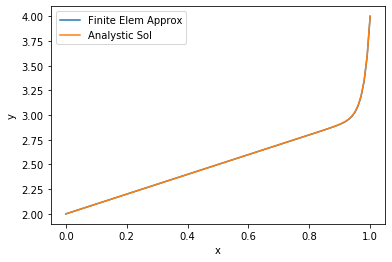

In [38]:
alpha, beta, epsilon, N = 2, 4, 0.02, 100
xmin, xmax = 0, 1

y = lambda x : alpha + x + (beta - alpha - 1) * (np.exp(x/epsilon)) / (np.exp(1/epsilon) - 1)

x = np.linspace(0, 1, 101)
plt.plot(x, finite_element(epsilon, alpha, beta, xmin, xmax, N), label="Finite Elem Approx")
plt.plot(x, y(x), label='Analystic Sol')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Problem 2

One of the strengths of the finite element method is the ability to generate grids
that better suit the problem. The solution of (10.5) changes most rapidly near x = 1. Compare
the numerical solution when the grid points are unevenly spaced versus when the grid points
are clustered in the area of greatest change; see Figure 10.4. Specifically, use the grid points
defined by

    even_grid = np.linspace(0,1,15)
    clustered_grid = np.linspace(0,1,15)**(1./8)

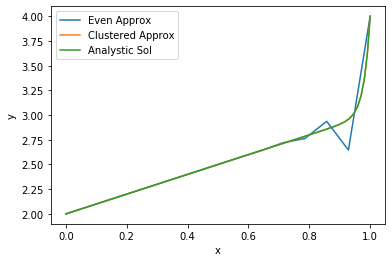

In [39]:
even_sol = finite_element(epsilon, alpha, beta, xmin, xmax, 14)
clustered_sol = finite_element(epsilon, alpha, beta, xmin, xmax, 14, special=True)
x = np.linspace(0, 1, 15)
plt.plot(x, even_sol, label='Even Approx')
x = np.linspace(0, 1, 15)**(1./8)
plt.plot(x, y(x), label="Clustered Approx")
plt.plot(x, y(x), label='Analystic Sol')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Problem 3

Higher order methods promise faster convergence, but typically require more work
to code. So why do we use them when a low order method will converge just as well, albeit
with more grid points? The answer concerns the roundoff error associated with floating point arithmetic. Low order methods generally require more floating point operations, so roundoff
error has a much greater effect.

The finite element method introduced here is a second order method, even though the
approximate solution is piecewise linear. (To see this, note that if the grid points are evenly
spaced, the matrix A in (10.4) is exactly the same as the matrix for the second order centered
finite difference method.)

Solve (10.5) with the finite element method using N = 2i finite elements, i = 4, 5, . . . , 21.
Use a log-log plot to graph the error; see Figure 10.5.

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


No handles with labels found to put in legend.


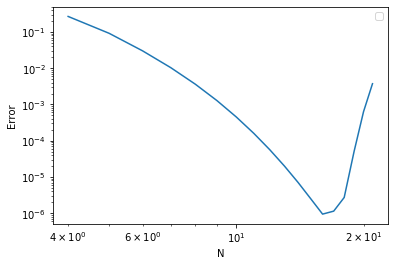

In [54]:
errors = []
for i in range(4, 22):
    N = 2**i
    print(i)
    x = np.linspace(0, 1, N+1)
    err = la.norm(finite_element(epsilon, alpha, beta, 0, 1, N) - y(x))
    errors.append(err)
plt.loglog(range(4, 22), errors)
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
plt.show()

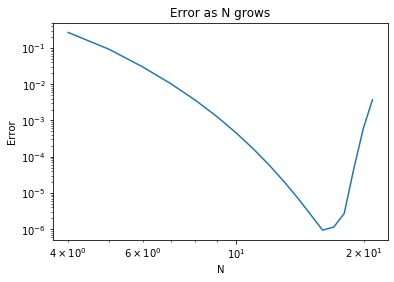

In [56]:
plt.loglog(range(4, 22), errors)
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Error as N grows")
plt.show()